In [2]:
import pymc as pm

# Taking draws from a normal distribution
seed = 42
x_dist = pm.Normal.dist(shape=(100, 3))
x_data = pm.draw(x_dist, random_seed=seed)

# Define coordinate values for all dimensions of the data
coords={
 "trial": range(100),
 "features": ["sunlight hours", "water amount", "soil nitrogen"],
}

# Define generative model
with pm.Model(coords=coords) as generative_model:
   x = pm.Data("x", x_data, dims=["trial", "features"])

   # Model parameters
   betas = pm.Normal("betas", dims="features")
   sigma = pm.HalfNormal("sigma")

   # Linear model
   mu = x @ betas

   # Likelihood
   # Assuming we measure deviation of each plant from baseline
   plant_growth = pm.Normal("plant growth", mu, sigma, dims="trial")


# Generating data from model by fixing parameters
fixed_parameters = {
 "betas": [5, 20, 2],
 "sigma": 0.5,
}
with pm.do(generative_model, fixed_parameters) as synthetic_model:
   idata = pm.sample_prior_predictive(random_seed=seed) # Sample from prior predictive distribution.
   synthetic_y = idata.prior["plant growth"].sel(draw=0, chain=0)


# Infer parameters conditioned on observed data
with pm.observe(generative_model, {"plant growth": synthetic_y}) as inference_model:
   idata = pm.sample(random_seed=seed)

   summary = pm.stats.summary(idata, var_names=["betas", "sigma"])
   print(summary)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
Sampling: [plant growth]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, sigma]


c:\repo\pymc_project\venv\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.


                         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
betas[sunlight hours]   4.973  0.053   4.872    5.071      0.001    0.001   
betas[water amount]    19.964  0.049  19.871   20.055      0.001    0.001   
betas[soil nitrogen]    1.996  0.056   1.895    2.100      0.001    0.001   
sigma                   0.511  0.037   0.445    0.582      0.000    0.001   

                       ess_bulk  ess_tail  r_hat  
betas[sunlight hours]    5469.0    3527.0    1.0  
betas[water amount]      5776.0    3157.0    1.0  
betas[soil nitrogen]     4913.0    3428.0    1.0  
sigma                    5603.0    3476.0    1.0  


In [ ]:
import arviz as az
import matplotlib.pyplot as plt

# First we need to generate posterior predictive samples
with inference_model:
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=seed))


Sampling: [plant growth]


c:\repo\pymc_project\venv\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

<Figure size 1000x600 with 0 Axes>

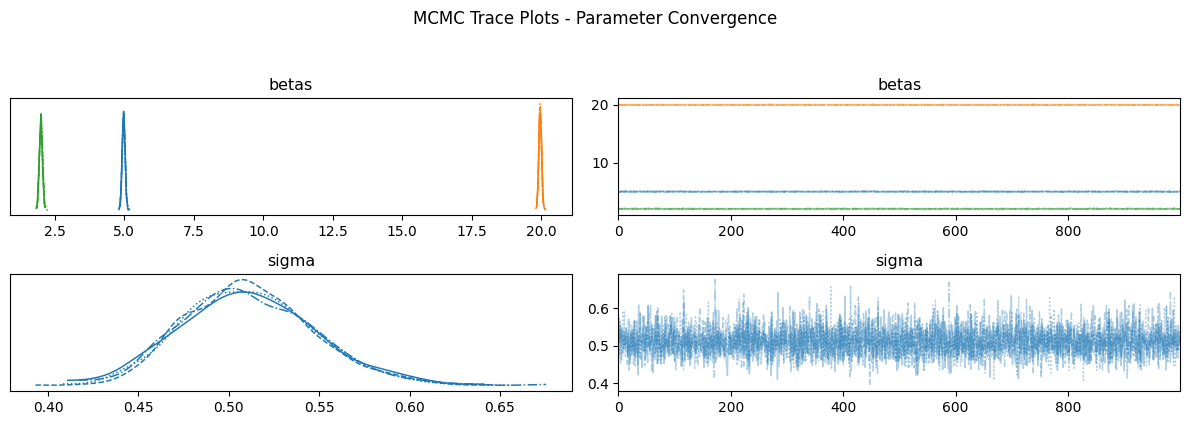

<Figure size 800x400 with 0 Axes>

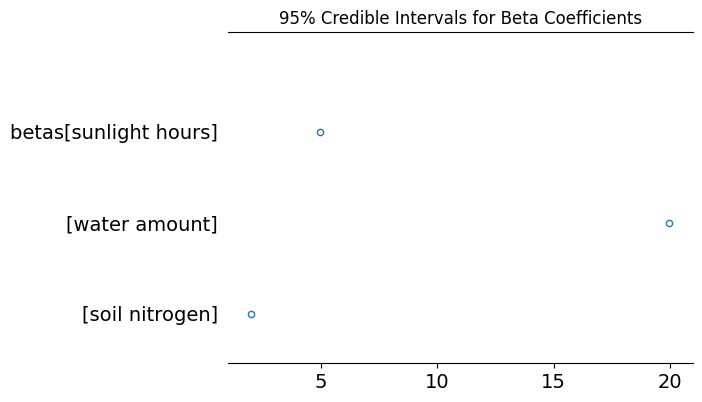

<Figure size 1000x500 with 0 Axes>

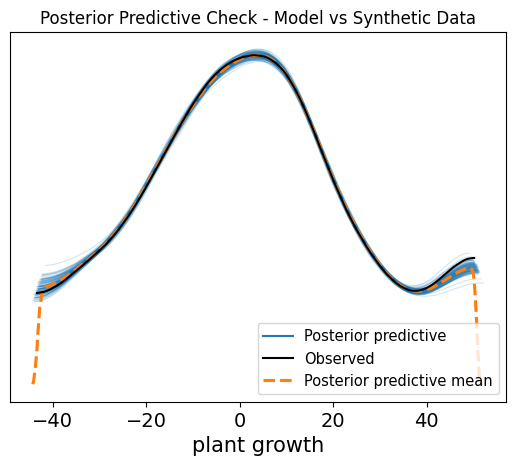

<Figure size 1000x800 with 0 Axes>

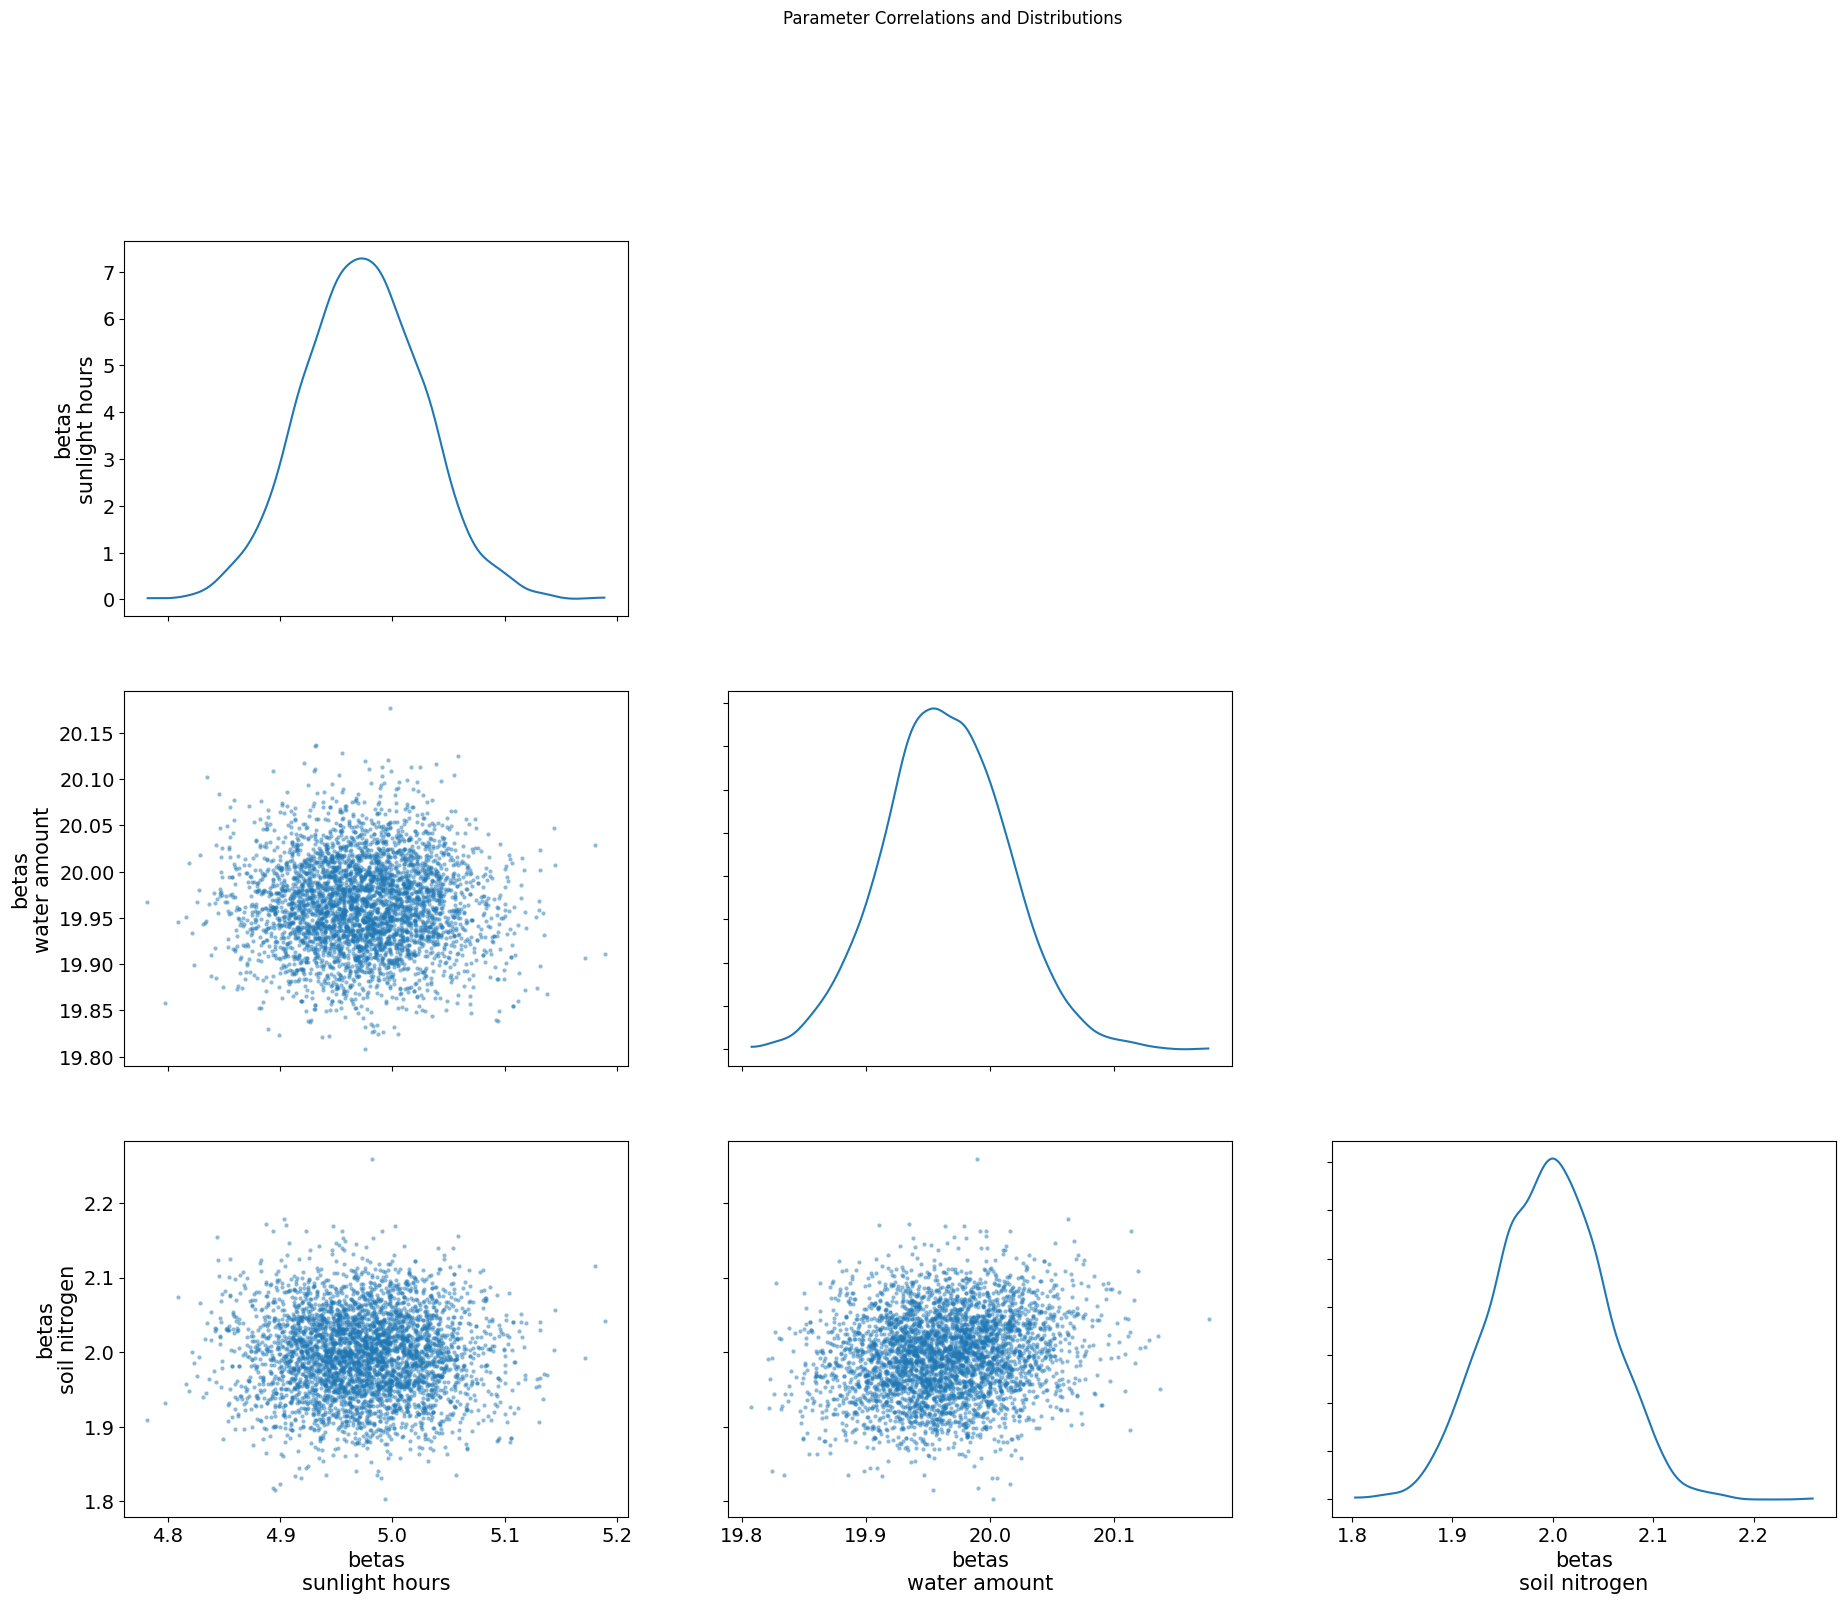

In [7]:
# 1. Trace Plot - Shows MCMC sampling performance
plt.figure(figsize=(10, 6))
az.plot_trace(idata, var_names=["betas", "sigma"])
plt.suptitle("MCMC Trace Plots - Parameter Convergence", y=1.05)
plt.tight_layout()
plt.savefig("./figures/trace_plot.png", dpi=300, bbox_inches='tight')

# 2. Forest Plot - Parameter estimates with credible intervals
plt.figure(figsize=(8, 4))
az.plot_forest(idata, var_names=["betas"], combined=True, hdi_prob=0.95)
plt.title("95% Credible Intervals for Beta Coefficients")
plt.savefig("./figures/forest_plot.png", dpi=300, bbox_inches='tight')

# 3. Posterior Predictive Check
plt.figure(figsize=(10, 5))
az.plot_ppc(idata, num_pp_samples=100)
plt.title("Posterior Predictive Check - Model vs Synthetic Data")
plt.savefig("./figures/ppc_plot.png", dpi=300, bbox_inches='tight')

# 4. Pair Plot - Parameter Correlations
plt.figure(figsize=(10, 8))
az.plot_pair(idata, var_names=["betas"], 
            marginals=True, 
            scatter_kwargs={'alpha': 0.5},
            divergences=True)
plt.suptitle("Parameter Correlations and Distributions", y=1.02)
plt.savefig("./figures/pair_plot.png", dpi=300, bbox_inches='tight')

# plt.close('all')  # Clean up